In [1]:
# In this homework, we will use Credit Card Data from book "Econometric Analysis".
#!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [3]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import roc_auc_score

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from tqdm.auto import tqdm

In [4]:
# Preparation 
# The goal of this homework is to inspect the output of different evaluation metrics 
#by creating a classification model (target column card).

df = pd.read_csv( "AER_credit_card_data.csv" )

# Create the target variable by mapping yes to 1 and no to 0.
df.card = (df.card == "yes").astype(int)

# Split the dataset into 3 parts: train/validation/test with 60%/20%/20% distribution. 
# Use train_test_split funciton for that with random_state=1.
df_train_val, df_test = train_test_split( df, test_size=0.2, random_state=1 )
df_train, df_val = train_test_split( df_train_val, test_size=0.2, random_state=1 )

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.card.values
y_val = df_val.card.values
y_test = df_test.card.values

del df_train['card']
del df_val['card']
del df_test['card']

In [5]:
# Question 1
# ROC AUC could also be used to evaluate feature importance of numerical variables.
# For each numerical variable, use it as score and compute AUC with the card variable.
# Use the training dataset for that.
num_col = df_train.dtypes[df_train.dtypes!=object].index.values
print(num_col)

num_col_obj = df_train.dtypes[df_train.dtypes==object].index.values
print(num_col_obj)

['reports' 'age' 'income' 'share' 'expenditure' 'dependents' 'months'
 'majorcards' 'active']
['owner' 'selfemp']


In [6]:
# If your AUC is < 0.5, invert this variable by putting "-" in front
# (e.g. -df_train['expenditure'])

# AUC can go below 0.5 if the variable is negatively correlated with the target varialble. 
# You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

column = []
score = []

for i in num_col:
    print(i)
    auc = roc_auc_score( y_train, df_train[i].values )
    print( round(auc, 3) )
    column.append(i)
    score.append(auc)
    
roc_auc = {}
roc_auc["variable"] = column
roc_auc["value"] = score
    
auc_table = pd.DataFrame( data = roc_auc, index = np.arange(len(column)) )  
auc_table.sort_values("value")

# Response = share

reports
0.288
age
0.486
income
0.59
share
0.99
expenditure
0.992
dependents
0.471
months
0.477
majorcards
0.536
active
0.61


,variable,value
0,reports,0.287972
5,dependents,0.470531
6,months,0.476823
1,age,0.485675
7,majorcards,0.536216
2,income,0.589766
8,active,0.610167
3,share,0.989976
4,expenditure,0.991629


In [7]:
# Training the Model
# rom now on, use these columns only:
# [“reports”, “age”, “income”, “share”, “expenditure”, “dependents”, “months”, “majorcards”, “active”, “owner”, “selfemp”]

selected_columns = ["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active", "owner", "selfemp"]
df_train = df_train[selected_columns]
print( df_train.columns )

Index(['reports', 'age', 'income', 'share', 'expenditure', 'dependents',
       'months', 'majorcards', 'active', 'owner', 'selfemp'],
      dtype='object')


In [8]:
#Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:
#LogisticRegression(solver=‘liblinear’, C=1.0, max_iter=1000)
dv = DictVectorizer(sparse=False)

train_dict = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [9]:
#Question 2
#What’s the AUC of this model on the validation dataset? (round to 3 digits)

val_dict = df_val.to_dict(orient="records")
X_val = dv.transform(val_dict)
y_pred = model.predict_proba(X_val)[:,1]
roc_auc_score(y_val, y_pred).round(3)

0.994

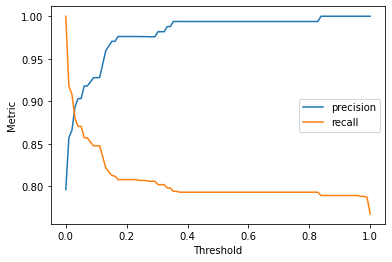

In [10]:
#Question 3
#Now let’s compute precision and recall for our model.

#Evaluate the model on the validation dataset on all thresholds from 0.0 to 1.0 with step 0.01
thresholds = np.linspace(0.0, 1.0, 100)
scores = []

#For each threshold, compute precision and recall
for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)
    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()
    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    scores.append((t, tp, fp, fn, tn))
    
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)

df_scores['precision'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['recall'] = df_scores.tp / (df_scores.tp + df_scores.tn)

#Plot them
df_plot = df_scores.loc[:, ('threshold', 'precision', 'recall')]

plt.plot(df_plot.threshold, df_plot['precision'], label='precision')
plt.plot(df_plot.threshold, df_plot['recall'], label='recall')
plt.xlabel('Threshold')
plt.ylabel('Metric')
plt.legend()
plt.show()

In [11]:
df_plot.iloc[0:20,]

,threshold,precision,recall
0,0.000000,0.796209,1.000000
1,0.010101,0.857143,0.918033
2,0.020202,0.865979,0.908108
3,0.030303,0.893617,0.879581
4,0.040404,0.903226,0.870466
5,0.050505,0.903226,0.870466
6,0.060606,0.918033,0.857143
7,0.070707,0.918033,0.857143
8,0.080808,0.922652,0.852041
9,0.090909,0.927778,0.847716


In [12]:
# Question 4
#Precision and recall are conflicting - when one grows, the other goes down. 
# That’s why they are often combined into the F1 score - a metrics that takes into account both
# Let’s compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01 using the validation set

df_scores["F1"] = 2 * ((df_scores.precision * df_scores.recall)/(df_scores.precision + df_scores.recall))
df_scores

,threshold,tp,fp,fn,tn,precision,recall,F1
0,0.000000,168,43,0,0,0.796209,1.000000,0.886544
1,0.010101,168,28,0,15,0.857143,0.918033,0.886544
2,0.020202,168,26,0,17,0.865979,0.908108,0.886544
3,0.030303,168,20,0,23,0.893617,0.879581,0.886544
4,0.040404,168,18,0,25,0.903226,0.870466,0.886544
...,...,...,...,...,...,...,...,...
95,0.959596,161,0,7,43,1.000000,0.789216,0.882192
96,0.969697,160,0,8,43,1.000000,0.788177,0.881543
97,0.979798,160,0,8,43,1.000000,0.788177,0.881543
98,0.989899,159,0,9,43,1.000000,0.787129,0.880886


In [13]:
# At which threshold F1 is maximal?
df_scores[df_scores["F1"] == df_scores.F1.max()]

,threshold,tp,fp,fn,tn,precision,recall,F1
2,0.020202,168,26,0,17,0.865979,0.908108,0.886544


In [14]:
def train(df_train, y_train, C=1.0):
    dicts = df_train.to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [15]:
def predict(df, dv, model):
    dicts = df.to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [16]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

scores = []

for train_idx, val_idx in kfold.split(df_train_val):
    df_train_fold = df_train_val.iloc[train_idx]
    df_val_fold = df_train_val.iloc[val_idx]
    
    y_train = df_train_fold.card.values
    y_val = df_val_fold.card.values
    
    dv, model = train(df_train_fold, y_train)
    y_pred = predict(df_val_fold, dv, model)
    
    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

In [17]:
round(np.mean(scores),3), round(np.std(scores),3)

(1.0, 0.0)

In [19]:
print( scores )

[1.0, 1.0, 1.0, 1.0, 1.0]


In [18]:
#Question 6
#Now let's use 5-Fold cross-validation to find the best parameter C

#Iterate over the following C values: [0.01, 0.1, 1, 10]
#Initialize KFold with the same parameters as previously
#Use these parametes for the model: LogisticRegression(solver='liblinear', C=C, max_iter=1000)
#Compute the mean score as well as the std (round the mean and std to 3 decimal digits)
n_splits = 5

for C in tqdm([0.01, 0.1, 1, 10]):
    
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_train_val):
        df_train = df_train_val.iloc[train_idx]
        df_val = df_train_val.iloc[val_idx]

        y_train = df_train.card.values
        y_val = df_val.card.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/4 [00:00<?, ?it/s]

C=0.01 0.993 +- 0.005
C=0.1 0.999 +- 0.001
C=1 1.000 +- 0.000
C=10 1.000 +- 0.000
